----
# <b> Mini Project ML for Time Series </b>
# Matteo MARENGO | matteo.marengo@ens-paris-saclay.fr
# Hugo ROBERT | hugo.robert@ens-paris-saclay.fr
----


# <b>Epilepsy Detection Using EEG Data</b>

In this example we'll use the |cesium|_ library to compare
various techniques for epilepsy detection using a classic EEG time series dataset from
[Andrzejak et al.](http://www.meb.uni-bonn.de/epileptologie/science/physik/eegdata.html).
The raw data are separated into <b>five classes: Z, O, N, F, and S;</b> we will consider a
three-class classification problem of distinguishing:
- normal (Z, O)
- interictal (N, F)
- ictal (S) signals

<b>The overall workflow consists of three steps: </b>
- 1) first, we "featurize" the time series by selecting some set of mathematical functions to apply to each;
- 2) next, we build some classification models which use these features to distinguish between classes;
- 3) finally, we validate our models by generating predictions for some unseen
holdout set and comparing them to the true class labels.

First, we'll load the data and inspect a representative time series from each class:

.. |cesium| replace:: ``cesium``


----
----
# <b> 1 : Load the Data </b>

In [ ]:
!pip install cesium
!pip install tsfel
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 526.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 8.4 MB/s eta 0:00:00


Size of EEG dictionary: 5
Size of Normal class: 200
Size of Interictal class: 200
Size of Ictal class: 100


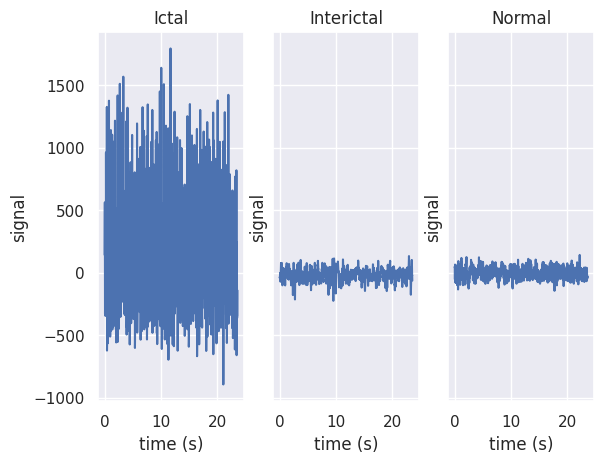

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from cesium import datasets

seaborn.set()

# Import the data
eeg = datasets.fetch_andrzejak()
# Size of the EEG dictionary
eeg_dict_size = len(eeg)
print("Size of EEG dictionary:", eeg_dict_size)

# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype("U16")  # allocate memory for longer class names

# NORMAL Classes
eeg["classes"][np.logical_or(eeg["classes"] == "Z", eeg["classes"] == "O")] = "Normal"
normal_indices = np.where(eeg["classes"] == "Normal")[0]
print("Size of Normal class:", normal_indices.size)
# INTERICTAL Classes
eeg["classes"][np.logical_or(eeg["classes"] == "N", eeg["classes"] == "F")] = "Interictal"
interictal_indices = np.where(eeg["classes"] == "Interictal")[0]
print("Size of Interictal class:", interictal_indices.size)
# ICTAL Classes
eeg["classes"][eeg["classes"] == "S"] = "Ictal"
ictal_indices = np.where(eeg["classes"] == "Ictal")[0]
print("Size of Ictal class:", ictal_indices.size)

# Plot one Ictal, one Interical, one Normal signal
fig, ax = plt.subplots(1, len(np.unique(eeg["classes"])), sharey=True)
for label, subplot in zip(np.unique(eeg["classes"]), ax):
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)

----
----
# <b> 2 : Featurization</b>
Once the data is loaded, we can generate features for each time series using the
|cesium.featurize|_ module. The ``featurize`` module includes many built-in
choices of features which can be applied for any type of time series data;
here we've chosen a few generic features that do not have any special
biological significance.

By default, the time series will featurized in parallel using the
``dask.threaded`` scheduler; other approaches, including serial and
distributed approaches, can be implemented by passing in other ``dask``
schedulers as the ``get`` argument to ``featurize_time_series``.

.. |cesium.featurize| replace:: ``cesium.featurize``



----
## <b> 2.1 : Cesium Features</b>

In [ ]:
from cesium import featurize

features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average",
]

fset_cesium = featurize.featurize_time_series(
    times=eeg["times"],
    values=eeg["measurements"],
    errors=None,
    features_to_use=features_to_use,
)

print(fset_cesium.head())
print("Type of fset_cesium: ",type(fset_cesium))
print("Shape of fset_cesium: ",fset_cesium.shape)

feature amplitude percent_beyond_1_std maximum     max_slope median  \
channel         0                    0       0             0      0   
0           143.5             0.327313   141.0  11107.796610   -4.0   
1           211.5             0.290212   169.0  20653.559322  -51.0   
2           165.0             0.302660   184.0  13537.627119   13.0   
3           171.5             0.300952   162.0  17008.813559   -4.0   
4           170.0             0.305101   152.0  13016.949153  -18.0   

feature median_absolute_deviation percent_close_to_median minimum      skew  \
channel                         0                       0       0         0   
0                            28.0                0.505004  -146.0  0.032805   
1                            32.0                0.640469  -254.0 -0.092715   
2                            31.0                0.515987  -146.0 -0.004100   
3                            31.0                0.541128  -181.0  0.063678   
4                           

The output of ``featurize_time_series`` is a ``pandas.DataFrame`` which contains all
the feature information needed to train a machine learning model:
- feature names are stored as column indices (as well as channel numbers, as we'll see
later for multi-channel data)
- the time series index/class label are stored as row indices.



----
## <b>2.2 : TSFEL Features</b>

In [ ]:
# Print the lengths of the measurements and times arrays
print("Length of 'measurements' array:", len(eeg["measurements"]))
print("Length of one measurement:", len(eeg["measurements"][0]))
print("Length of one time series:", len(eeg["times"][0]))

# Calculate the sampling period Ts
Ts = eeg["times"][0][1] - eeg["times"][0][0]
print("Sampling period (Ts):", Ts)

# Define the sampling frequency
fs = 1 / Ts
print("Sampling frequency (fs):", fs)

Length of 'measurements' array: 500
Length of one measurement: 4097
Length of one time series: 4097
Sampling period (Ts): 0.00576171875
Sampling frequency (fs): 173.5593220338983


In [ ]:
import tsfel

# Extract all features
cfg_file = tsfel.get_features_by_domain()
# cfg_file = tsfel.get_features_by_domain('statistical') # Only statistical features
# cfg_file = tsfel.get_features_by_domain('temporal')    # Only temporal features
# cfg_file = tsfel.get_features_by_domain('spectral')    # Only spectral features

fset_tsfel = tsfel.time_series_features_extractor(cfg_file, eeg["measurements"], fs=fs)
# print type of fset_tsfel (pandas dataframe)
print("Shape of fset_tsfel: ",type(fset_tsfel))

*** Feature extraction started ***



*** Feature extraction finished ***
<class 'pandas.core.frame.DataFrame'>


In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

# Highly correlated features are removed
corr_features = tsfel.correlated_features(fset_tsfel)
fset_tsfel.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
fset_tsfel = selector.fit_transform(fset_tsfel)

# Normalising Features
scaler = preprocessing.StandardScaler()
fset_tsfel = scaler.fit_transform(fset_tsfel)

In [ ]:
import pandas as pd
print("Type of fset_tsfel: ",type(fset_tsfel))
print("Shape of fset_tsfel: ",fset_tsfel.shape)
# Convert the numpy array into a pandas dataframe
fset_tsfel = pd.DataFrame(fset_tsfel)
print(type(fset_tsfel))

<class 'numpy.ndarray'>
(500, 173)


----
## <b> 2.3 : Custom feature functions</b>
Custom feature functions not built into ``cesium`` may be passed in using the
``custom_functions`` keyword, either as a dictionary ``{feature_name: function}``, or as a
[dask graph](http://dask.pydata.org/en/latest/custom-graphs.html). Functions should take
three arrays ``times, measurements, errors`` as inputs; details can be found in the
``cesium.featurize``
[documentation](http://cesium-ml.org/docs/api/cesium.featurize.html).

Here we'll compute five standard features for EEG analysis provided by
[Guo et al. (2012)](http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253)):



In [ ]:
import scipy.stats

def mean_signal(t, m, e):
    return np.mean(m)


def std_signal(t, m, e):
    return np.std(m)


def mean_square_signal(t, m, e):
    return np.mean(m**2)


def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))


def skew_signal(t, m, e):
    return scipy.stats.skew(m)

Now we'll pass the desired feature functions as a dictionary via the
``custom_functions`` keyword argument.



In [ ]:
guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean2": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "skew": skew_signal,
}

fset_guo = featurize.featurize_time_series(
    times=eeg["times"],
    values=eeg["measurements"],
    errors=None,
    features_to_use=list(guo_features.keys()),
    custom_functions=guo_features,
)
print(fset_guo.head())
print(fset_guo.shape)
print(type(fset_guo))

feature       mean        std        mean2 abs_diffs      skew
channel          0          0            0         0         0
0        -4.132048  40.411000  1650.122773   46948.0  0.032805
1       -52.444716  48.812668  5133.124725   61118.0 -0.092715
2        12.705150  47.144789  2384.051989   51269.0 -0.004100
3        -3.992433  47.072316  2231.742495   75014.0  0.063678
4       -17.999268  44.910958  2340.967781   52873.0  0.142753
(500, 5)
<class 'pandas.core.frame.DataFrame'>


----
## <b> 2.4 : Multi-channel time series</b>
The EEG time series considered here consist of univariate signal measurements along a
uniform time grid. But ``featurize_time_series`` also accepts multi-channel
data; to demonstrate this, we will decompose each signal into <b>five frequency
bands using a discrete wavelet transform</b> as suggested by
[Subasi (2005)](http://www.sciencedirect.com/science/article/pii/S0957417404001745),
and then featurize each band separately using the five functions from above.



In [ ]:
import pywt

n_channels = 5
eeg["dwts"] = [
    pywt.wavedec(m, pywt.Wavelet("db1"), level=n_channels - 1)
    for m in eeg["measurements"]
]
fset_dwt = featurize.featurize_time_series(
    times=None,
    values=eeg["dwts"],
    errors=None,
    features_to_use=list(guo_features.keys()),
    custom_functions=guo_features,
)
print(fset_dwt.head())
print(type(fset_dwt))
print(fset_dwt.shape)

feature        mean                                                 std  \
channel           0         1         2         3         4           0   
0        -17.080739 -6.067121 -0.979336  0.154634  0.035545  112.473774   
1       -210.210117 -3.743191  0.511377  0.057561 -0.024847  119.836067   
2         51.831712  0.714981  0.247418 -0.101951  0.007937  134.809626   
3        -15.429961  9.348249 -0.099243 -0.228293  0.181522  104.420503   
4        -71.982490 -3.787938 -0.183324 -0.034146 -0.048314  124.012203   

feature                                              ... abs_diffs            \
channel          1          2          3          4  ...         0         1   
0        72.970862  48.167301  25.774846  10.154899  ...  25127.00  18056.00   
1        92.777487  67.005780  33.957464  13.673398  ...  28742.00  25226.00   
2        78.294247  60.275759  28.088980  11.246134  ...  28284.75  19826.25   
3        89.999242  67.249397  35.929621  16.366747  ...  24848.25  25715.

The output feature set has the same form as before, except now the ``channel``
component of the column index is used to index the features by the
corresponding frequency band.



----
## <b> 2.5 : TSFRESH Features

----
### <b> 2.5.1 : Create the Dataframe </b>

In [ ]:
# List to hold the temporary DataFrames
print(type(eeg["measurements"]))
print(len(eeg["measurements"]))
print(len(eeg["measurements"][0]))

# Assuming time_series_list and time_list are defined as follows:
time_series_list = eeg["measurements"]
time_list = eeg["times"]

data = []

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(time_series_list, time_list)):
    if len(series) != len(times):
        raise ValueError(f"Length mismatch in series {i}: {len(series)} measurements, {len(times)} time points.")

    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df = pd.DataFrame(data)

print(len(df))
print(df.head)
print(df.shape)

<class 'list'>
500
4097
2048500
<bound method NDFrame.head of           id       time  value
0          0   0.000000   40.0
1          0   0.005762   48.0
2          0   0.011523   35.0
3          0   0.017285    5.0
4          0   0.023047  -40.0
...      ...        ...    ...
2048495  499  23.576953    7.0
2048496  499  23.582715   26.0
2048497  499  23.588477   57.0
2048498  499  23.594238   95.0
2048499  499  23.600000  462.0

[2048500 rows x 3 columns]>
(2048500, 3)


In [ ]:
dftrain

----
### <b> 2.5.2 : MinimalFCParameters </b>

In [ ]:
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters,ComprehensiveFCParameters
from tsfresh import select_features,extract_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
# Use MinimalFCParameters
extraction_settings = MinimalFCParameters()

# Feature extraction with error handling and progress information
try:
    fset_tsfresh_mini = extract_features(df, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(fset_tsfresh_mini))
    print("Number of features extracted:", len(fset_tsfresh_mini.columns))
    print("Shape of the feature set:", fset_tsfresh_mini.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

Feature Extraction: 100%|██████████| 500/500 [00:00<00:00, 643.66it/s]

Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 10
Shape of the feature set: (500, 10)


----
### <b> 2.5.3 : EfficientFCParameters </b>

In [ ]:
# Use EfficientFCParameters for a more comprehensive feature set
extraction_settings = EfficientFCParameters()

# Feature extraction with error handling and progress information
try:
    fset_tsfresh = extract_features(df, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(fset_tsfresh))
    print("Number of features extracted:", len(fset_tsfresh.columns))
    print("Shape of the feature set:", fset_tsfresh.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

Feature Extraction: 100%|██████████| 500/500 [07:58<00:00,  1.04it/s]


<class 'pandas.core.frame.DataFrame'>
500
(500, 777)


----
----
# <b> 3 : Model Building</b>
Featuresets produced by ``cesium.featurize`` are compatible with the ``scikit-learn``
API.

For this example, we'll test a random forest classifier for the
built-in ``cesium`` features, and a 3-nearest neighbors classifier for the
others, as suggested by
[Guo et al. (2012)](http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253).



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

train, test = train_test_split(np.arange(len(eeg["classes"])), random_state=0)

model_cesium = RandomForestClassifier(n_estimators=128, random_state=0)
model_cesium.fit(fset_cesium.iloc[train], eeg["classes"][train])

model_tsfel = RandomForestClassifier(n_estimators=128, random_state=0)
model_tsfel.fit(fset_tsfel.iloc[train], eeg["classes"][train])

model_tsfresh = RandomForestClassifier(n_estimators=128, random_state=0)
model_tsfresh.fit(fset_tsfresh.iloc[train], eeg["classes"][train])

model_tsfresh_mini = RandomForestClassifier(n_estimators=128, random_state=0)
model_tsfresh_mini.fit(fset_tsfresh_mini.iloc[train], eeg["classes"][train])

model_guo = KNeighborsClassifier(3)
model_guo.fit(fset_guo.iloc[train], eeg["classes"][train])

model_dwt = KNeighborsClassifier(3)
model_dwt.fit(fset_dwt.iloc[train], eeg["classes"][train])


KNeighborsClassifier(n_neighbors=3)

----
----
# <b> 4 : Prediction</b>
Making predictions for new time series based on these models follows the same
pattern: first the time series are featurized using ``featurize_time_series``,
and then predictions are made based on these features using the ``predict``
method of the ``scikit-learn`` model.



Built-in cesium features: training accuracy=100.00%, test accuracy=83.20%
Built-in tsfel features: training accuracy=100.00%, test accuracy=96.80%
Built-in tsfresh features: training accuracy=100.00%, test accuracy=94.40%
Built-in tsfresh_mini features: training accuracy=100.00%, test accuracy=76.00%
Guo et al. features: training accuracy=92.80%, test accuracy=83.20%
Wavelet transform features: training accuracy=97.87%, test accuracy=95.20%


                   Training Accuracy  Test Accuracy
Cesium                      1.000000          0.832
TSFEL                       1.000000          0.968
TSFresh                     1.000000          0.944
TSFresh Mini                1.000000          0.760
Guo et al.                  0.928000          0.832
Wavelet Transform           0.978667          0.952


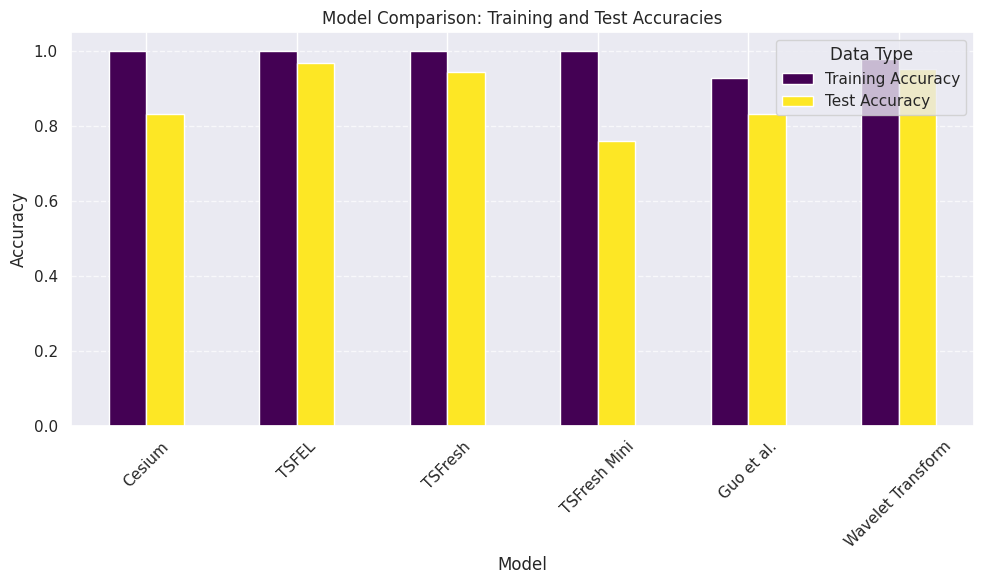

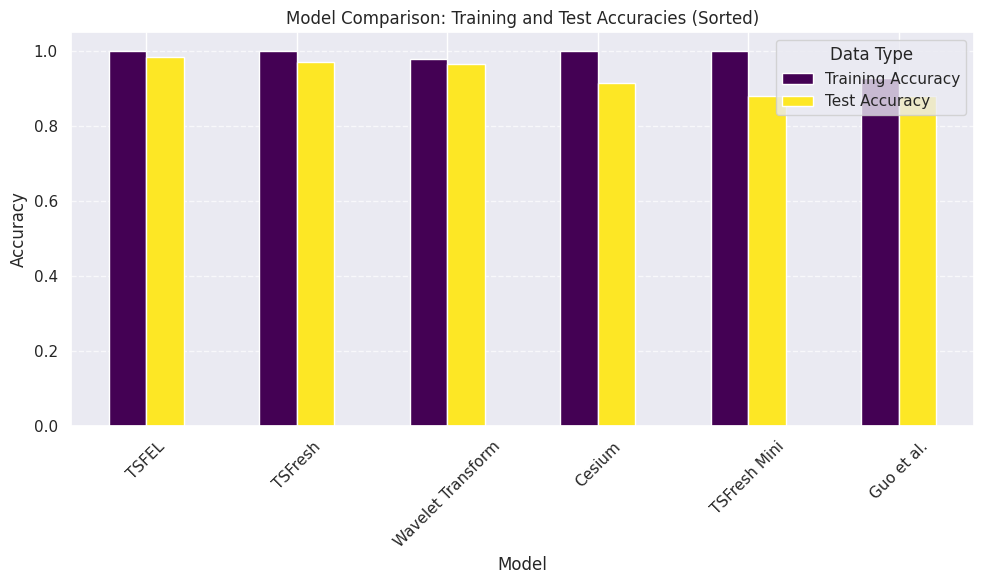

In [ ]:
from sklearn.metrics import accuracy_score

preds_cesium = model_cesium.predict(fset_cesium)
preds_tsfel = model_tsfel.predict(fset_tsfel)
preds_tsfresh = model_tsfresh.predict(fset_tsfresh)
preds_tsfresh_mini = model_tsfresh_mini.predict(fset_tsfresh_mini)
preds_guo = model_guo.predict(fset_guo)
preds_dwt = model_dwt.predict(fset_dwt)

print(
    "Built-in cesium features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        accuracy_score(preds_cesium[train], eeg["classes"][train]),
        accuracy_score(preds_cesium[test], eeg["classes"][test]),
    )
)

print(
    "Built-in tsfel features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        accuracy_score(preds_tsfel[train], eeg["classes"][train]),
        accuracy_score(preds_tsfel[test], eeg["classes"][test]),
    )
)

print(
    "Built-in tsfresh features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        accuracy_score(preds_tsfresh[train], eeg["classes"][train]),
        accuracy_score(preds_tsfresh[test], eeg["classes"][test]),
    )
)

print(
    "Built-in tsfresh_mini features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        accuracy_score(preds_tsfresh_mini[train], eeg["classes"][train]),
        accuracy_score(preds_tsfresh_mini[test], eeg["classes"][test]),
    )
)


print(
    "Guo et al. features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        accuracy_score(preds_guo[train], eeg["classes"][train]),
        accuracy_score(preds_guo[test], eeg["classes"][test]),
    )
)
print(
    "Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        accuracy_score(preds_dwt[train], eeg["classes"][train]),
        accuracy_score(preds_dwt[test], eeg["classes"][test]),
    )
)

# Store the results in a dictionary
results = {
    "Cesium": [accuracy_score(preds_cesium[train], eeg["classes"][train]), accuracy_score(preds_cesium[test], eeg["classes"][test])],
    "TSFEL": [accuracy_score(preds_tsfel[train], eeg["classes"][train]), accuracy_score(preds_tsfel[test], eeg["classes"][test])],
    "TSFresh": [accuracy_score(preds_tsfresh[train], eeg["classes"][train]), accuracy_score(preds_tsfresh[test], eeg["classes"][test])],
    "TSFresh Mini": [accuracy_score(preds_tsfresh_mini[train], eeg["classes"][train]), accuracy_score(preds_tsfresh_mini[test], eeg["classes"][test])],
    "Guo et al.": [accuracy_score(preds_guo[train], eeg["classes"][train]), accuracy_score(preds_guo[test], eeg["classes"][test])],
    "Wavelet Transform": [accuracy_score(preds_dwt[train], eeg["classes"][train]), accuracy_score(preds_dwt[test], eeg["classes"][test])]
}

# Convert the dictionary to a DataFrame for better visualization
df_results = pd.DataFrame(results, index=["Training Accuracy", "Test Accuracy"]).T

# Print the DataFrame
print("\n")
print(df_results)

# Plotting
ax = df_results.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Model Comparison: Training and Test Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Type')
plt.tight_layout()

# Show or save the plot
plt.show()

# Calculate the average accuracy and sort by it
df_results['Test Accuracy'] = df_results.mean(axis=1)
df_results_sorted = df_results.sort_values(by='Test Accuracy', ascending=False)

# Plotting
ax = df_results_sorted[['Training Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Model Comparison: Training and Test Accuracies (Sorted)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Type')
plt.tight_layout()

The workflow presented here is intentionally simplistic and omits many important steps
such as feature selection, model parameter selection, etc., which may all be
incorporated just as they would for any other ``scikit-learn`` analysis.
But with essentially three function calls (``featurize_time_series``,
``model.fit``, and ``model.predict``), we are able to build a
model from a set of time series and make predictions on new, unlabeled data. In
upcoming posts we'll introduce the web frontend for ``cesium`` and describe how
the same analysis can be performed in a browser with no setup or coding required.

